In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.python.estimator.export.export_output import PredictOutput

tf.logging.set_verbosity(tf.logging.INFO)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!rm -rf logdir-big

In [3]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

train_data = np.empty([0,32,32,3])
train_labels = np.empty([0])

for i in range(1,6):
    path = os.path.join(os.getcwd(), 'cifar-10-batches-py/data_batch_' + str(i))
    batch = unpickle(path)
    images = batch['data'].reshape(10000,3,32,32)
    train_data = np.append(train_data, np.transpose(images, (0, 2, 3, 1)), axis=0)
    labels = np.asarray(batch['labels'])
    train_labels = np.append(train_labels, labels)
    
path = os.path.join(os.getcwd(), 'cifar-10-batches-py/test_batch')
batch = unpickle(path)
images = batch['data'].reshape(10000,3,32,32)
eval_data = np.transpose(images, (0, 2, 3, 1))
eval_labels = np.asarray(batch['labels']).astype(dtype=np.int32)
train_labels = train_labels.astype(dtype=np.int32)

train_data= np.true_divide(train_data,256).astype(dtype=np.float32)
eval_data= np.true_divide(eval_data,256).astype(dtype=np.float32)

print('train_data shape:   ' + str(train_data.shape) + str(train_data.dtype))
print('train_labels shape: ' + str(train_labels.shape) + str(train_labels.dtype))

print('eval_data shape:    ' + str(eval_data.shape) + str(eval_data.dtype))
print('eval_labels shape:  ' + str(eval_labels.shape) + str(eval_labels.dtype))

train_data shape:   (50000, 32, 32, 3)float32
train_labels shape: (50000,)int32
eval_data shape:    (10000, 32, 32, 3)float32
eval_labels shape:  (10000,)int32


In [4]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=features["x"],
        filters=20,
        kernel_size=3,
        padding="valid",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=50,
        kernel_size=2,
        padding="valid",
        activation=tf.nn.relu)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2)
    
    # Convolutional Layer #3
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=200,
        kernel_size=1,
        padding="valid",
        activation=tf.nn.relu)

    # Pooling Layer #3
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=2, strides=2)
    
    # Dense Layer
    pool3_flat = tf.reshape(pool3, [-1, 3 * 3 * 200])
    dense = tf.layers.dense(inputs=pool3_flat, units=2048, activation=tf.nn.relu)
    dense1 = tf.layers.dense(inputs=dense, units=2048, activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1, units=2048, activation=tf.nn.relu)
    dense3 = tf.layers.dense(inputs=dense2, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense3, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    export_outputs={"SIGNATURE_NAME": PredictOutput({
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="final_result")
    })}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,export_outputs=export_outputs)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./logdir-big")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3b95f14b10>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './logdir-big', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [6]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "final_result"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [7]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=256,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./logdir-big/model.ckpt.
INFO:tensorflow:probabilities = [[0.10203083 0.0965322  0.10242556 ... 0.10004254 0.10232572 0.0946518 ]
 [0.1025539  0.09846049 0.10263402 ... 0.10263786 0.1043484  0.09464316]
 [0.10238167 0.09931035 0.10497736 ... 0.10147641 0.10265118 0.09704144]
 ...
 [0.10065125 0.0993517  0.10383034 ... 0.10078764 0.09998455 0.09792245]
 [0.10167009 0.09673638 0.10296423 ... 0.09988414 0.10379549 0.09849227]
 [0.09926338 0.09758027 0.10228503 ... 0.10037309 0.10352589 0.09506129]]
INFO:tensorflow:loss = 2.302977, step = 0
INFO:tensorflow:probabilities = [[0.02688915 0.02501896 0.09807284 ... 0.19021413 0.0165534  0.03877529]
 [0.18031788 0.14610526 0.03294702 ... 0.0323419  0.3957639  0.144756

INFO:tensorflow:loss = 0.85557187, step = 700 (3.278 sec)
INFO:tensorflow:probabilities = [[0.00113887 0.00050711 0.07682243 ... 0.06567742 0.00485554 0.00250282]
 [0.00166359 0.0795328  0.009488   ... 0.00078487 0.00031103 0.03166982]
 [0.00866237 0.00912972 0.43329626 ... 0.06424953 0.00174998 0.00728811]
 ...
 [0.04455969 0.00534336 0.00729608 ... 0.00069399 0.91731507 0.01232507]
 [0.00362282 0.00015475 0.7794491  ... 0.01962776 0.00083468 0.00013549]
 [0.03727418 0.00746543 0.00092462 ... 0.00003449 0.94610184 0.0067349 ]] (1.648 sec)
INFO:tensorflow:global_step/sec: 30.3197
INFO:tensorflow:probabilities = [[0.74201256 0.00232719 0.02146482 ... 0.001492   0.2108453  0.00828004]
 [0.06168913 0.00084851 0.8031112  ... 0.01263167 0.00088687 0.00036624]
 [0.00222514 0.03194465 0.00232831 ... 0.00558648 0.00267804 0.9121663 ]
 ...
 [0.00479917 0.00046404 0.11034737 ... 0.00352141 0.00109801 0.00031073]
 [0.02040342 0.00412473 0.03324955 ... 0.01256848 0.18440308 0.03423496]
 [0.0044649

INFO:tensorflow:loss = 0.49301177, step = 1500 (3.259 sec)
INFO:tensorflow:probabilities = [[0.9732026  0.00000004 0.02664728 ... 0.00000008 0.00002776 0.00000038]
 [0.00039577 0.00000218 0.99097836 ... 0.0001415  0.00005068 0.00000084]
 [0.00003442 0.00000022 0.9989293  ... 0.00002256 0.00000132 0.0000008 ]
 ...
 [0.00335469 0.00431924 0.00005047 ... 0.45841238 0.00023914 0.53329587]
 [0.00003779 0.00000013 0.9981365  ... 0.00000197 0.00000445 0.00000018]
 [0.00011255 0.00012631 0.01303807 ... 0.00000225 0.00003593 0.00002295]] (1.629 sec)
INFO:tensorflow:global_step/sec: 30.5156
INFO:tensorflow:probabilities = [[0.9869949  0.00001666 0.0065019  ... 0.00000208 0.00594307 0.00007067]
 [0.00319862 0.2978454  0.00151921 ... 0.00130876 0.00259838 0.68803567]
 [0.06339098 0.00011234 0.90443075 ... 0.00002087 0.00391384 0.0003672 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000066 0.00000033 0.00895175 ... 0.00880942 0.00000599 0.00000339]
 [0.002659

INFO:tensorflow:loss = 0.18160343, step = 2300 (3.276 sec)
INFO:tensorflow:probabilities = [[0.00006996 0.00016657 0.00865933 ... 0.00816737 0.00001177 0.0000913 ]
 [0.00000012 0.00000022 0.00003794 ... 0.0000005  0.         0.00000002]
 [0.00000036 0.00003224 0.0000112  ... 0.00000013 0.00000014 0.00000968]
 ...
 [0.0000113  0.00013253 0.00055087 ... 0.00029261 0.00000456 0.00003393]
 [0.00059033 0.1320669  0.0000781  ... 0.00007849 0.0314728  0.8353809 ]
 [0.99990356 0.00001016 0.0000218  ... 0.00000247 0.00003654 0.00002139]] (1.635 sec)
INFO:tensorflow:global_step/sec: 30.6063
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         1.         0.        ]
 [0.0000045  0.9997305  0.00006198 ... 0.00000265 0.00001294 0.00010439]
 [0.         0.         0.00000023 ... 0.00000004 0.         0.        ]
 ...
 [0.         0.00000002 0.00001139 ... 0.00000258 0.00000001 0.00000004]
 [0.01966002 0.00476367 0.17528781 ... 0.3585271  0.00112028 0.00153441]
 [0.000007

INFO:tensorflow:loss = 0.07616329, step = 3100 (3.284 sec)
INFO:tensorflow:probabilities = [[0.997844   0.00000724 0.00019263 ... 0.00004519 0.00015365 0.00038197]
 [0.00648838 0.00244331 0.0002305  ... 0.00020795 0.65395725 0.335114  ]
 [0.00000237 0.00000032 0.00011202 ... 0.00026738 0.00000107 0.00000738]
 ...
 [0.9992649  0.00000073 0.00000367 ... 0.00000147 0.0006777  0.00004102]
 [0.00001848 0.9980946  0.00000048 ... 0.00070445 0.00000002 0.00117638]
 [0.         0.         0.         ... 0.9999989  0.         0.        ]] (1.646 sec)
INFO:tensorflow:global_step/sec: 30.4366
INFO:tensorflow:probabilities = [[0.00000264 0.00001054 0.03692501 ... 0.001764   0.00003528 0.00016291]
 [0.00000002 0.00000004 0.         ... 0.00000001 0.00000002 0.9999999 ]
 [0.00172892 0.00000274 0.00000326 ... 0.00000001 0.9982389  0.00002094]
 ...
 [0.         0.9989367  0.         ... 0.         0.         0.00106329]
 [0.         0.         0.00001173 ... 0.00000227 0.00000001 0.00000001]
 [0.      

INFO:tensorflow:loss = 0.020036334, step = 3900 (3.289 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000206 0.00000176 0.99996793 ... 0.00002687 0.         0.00000024]
 [0.03933877 0.00000003 0.9606553  ... 0.00000006 0.00000036 0.00000008]
 ...
 [0.0000001  0.00000356 0.00166642 ... 0.00046976 0.00000159 0.00003586]
 [0.         0.         0.00000002 ... 0.99999976 0.         0.00000002]
 [0.         0.         0.         ... 0.         0.         1.        ]] (1.641 sec)
INFO:tensorflow:global_step/sec: 30.4078
INFO:tensorflow:probabilities = [[0.00000246 0.00000093 0.0482528  ... 0.00000168 0.00002452 0.00000008]
 [0.         0.00000003 0.         ... 0.         0.         1.        ]
 [0.00000001 0.         0.9999875  ... 0.00000001 0.00000001 0.        ]
 ...
 [0.00000694 0.00000077 0.9997415  ... 0.00000784 0.00000692 0.00000236]
 [0.0001923  0.00005651 0.00002569 ... 0.00258226 0.00005282 0.9956299 ]
 [0.00000

INFO:tensorflow:loss = 0.025278501, step = 4700 (3.275 sec)
INFO:tensorflow:probabilities = [[0.00001611 0.00000002 0.         ... 0.         0.9999839  0.        ]
 [0.00000011 0.         0.0000263  ... 0.00043604 0.00000003 0.00000003]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00000126 0.         0.99993694 ... 0.00000107 0.00000101 0.00000012]
 [0.00001769 0.         0.9999809  ... 0.00000002 0.00000002 0.        ]
 [0.9999926  0.00000017 0.0000002  ... 0.00000049 0.00000079 0.00000273]] (1.640 sec)
INFO:tensorflow:global_step/sec: 30.5006
INFO:tensorflow:probabilities = [[0.00002224 0.00000178 0.0000406  ... 0.00005096 0.0000247  0.00000265]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.0004352  0.00014436 0.27946684 ... 0.00371156 0.00265032 0.00080946]
 [0.0000067  0.00000073 0.00000469 ... 0.999108   0.00000002 0.0000036 ]
 [0.00000

INFO:tensorflow:loss = 0.019130273, step = 5500 (3.273 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000007 ... 0.         0.         0.00000002]
 [0.         0.00000014 0.00000061 ... 0.00001321 0.00000003 0.00000031]
 [0.9999964  0.00000002 0.00000003 ... 0.00000116 0.00000236 0.00000008]
 ...
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.99999964 0.         ... 0.         0.00000039 0.        ]
 [0.11299933 0.0000481  0.00005938 ... 0.00000812 0.886711   0.00003619]] (1.647 sec)
INFO:tensorflow:global_step/sec: 30.3923
INFO:tensorflow:probabilities = [[0.00571517 0.0000083  0.00008452 ... 0.00007692 0.00002583 0.00011785]
 [0.         0.00007071 0.00000028 ... 0.00000008 0.00000001 0.999843  ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00000001 0.         0.00000157 ... 0.00000104 0.         0.        ]
 [0.0000001  0.         0.9999559  ... 0.         0.         0.        ]
 [0.     

INFO:tensorflow:loss = 0.049298085, step = 6300 (3.280 sec)
INFO:tensorflow:probabilities = [[0.00001108 0.00000019 0.00000003 ... 0.         0.9999887  0.00000003]
 [0.00000554 0.00000643 0.00000574 ... 0.00000006 0.00000006 0.00000155]
 [0.00000011 0.00000005 0.00000785 ... 0.00000612 0.00000042 0.00000007]
 ...
 [0.00000249 0.00000048 0.86508805 ... 0.00002184 0.00000357 0.00002052]
 [0.00007849 0.00013898 0.00009833 ... 0.00035096 0.00299412 0.00574944]
 [0.         0.         0.00000045 ... 0.         0.         0.        ]] (1.645 sec)
INFO:tensorflow:global_step/sec: 30.4402
INFO:tensorflow:probabilities = [[0.00000006 0.00000012 0.00000143 ... 0.00001117 0.0000001  0.00000054]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.00000238 0.00000001 ... 0.00000002 0.00000025 0.99999726]
 ...
 [0.00000001 0.         0.9999988  ... 0.00000006 0.         0.        ]
 [0.00000008 0.00000014 0.00000276 ... 0.00000368 0.00000013 0.00000237]
 [0.00001

INFO:tensorflow:loss = 0.0316313, step = 7100 (3.269 sec)
INFO:tensorflow:probabilities = [[0.         0.99999964 0.         ... 0.00000001 0.         0.00000042]
 [0.00012716 0.00000569 0.0001827  ... 0.00002306 0.00195218 0.00021916]
 [0.0000009  0.         0.9999989  ... 0.         0.00000002 0.        ]
 ...
 [0.0000003  0.00000043 0.9999951  ... 0.00000119 0.00000015 0.00000137]
 [0.00002697 0.         0.9999579  ... 0.0000003  0.00000018 0.00000005]
 [0.00000001 0.         0.         ... 0.         0.         1.        ]] (1.641 sec)
INFO:tensorflow:global_step/sec: 30.4406
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.00000001 0.9999964  0.00000114 ... 0.         0.00000012 0.00000207]
 ...
 [0.00201578 0.00415829 0.00142628 ... 0.1886083  0.00164757 0.787384  ]
 [0.99999917 0.00000004 0.00000006 ... 0.         0.0000005  0.00000022]
 [0.       

INFO:tensorflow:loss = 0.057469767, step = 7900 (3.279 sec)
INFO:tensorflow:probabilities = [[0.00000011 0.         0.9999999  ... 0.         0.         0.        ]
 [0.00000139 0.00000203 0.00001228 ... 0.9969771  0.00000038 0.00000536]
 [0.         0.         0.00000008 ... 0.9998473  0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.00000011 0.00000692 0.         ... 0.00000013 0.         0.99999285]] (1.644 sec)
INFO:tensorflow:global_step/sec: 30.4345
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000499 0.00000001 0.00000013 ... 0.         0.99999475 0.00000011]
 [0.99999785 0.         0.00000001 ... 0.         0.00000216 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.     

INFO:tensorflow:loss = 0.033652723, step = 8700 (3.272 sec)
INFO:tensorflow:probabilities = [[0.         0.00000004 0.00001161 ... 0.00000056 0.00000007 0.00000001]
 [0.         0.00000021 0.         ... 0.         0.00000022 0.9999995 ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.0000004  0.00000313 ... 0.00000046 0.00000003 0.00000015]
 [0.         0.         0.00000001 ... 0.00000001 0.         0.        ]
 [0.00000006 0.00000005 0.00007344 ... 0.00000017 0.00000182 0.00000311]] (1.644 sec)
INFO:tensorflow:global_step/sec: 30.4052
INFO:tensorflow:probabilities = [[0.00000101 0.00000077 0.0000152  ... 0.00000027 0.0000005  0.00000087]
 [0.00000007 0.00000002 0.00000117 ... 0.00000002 0.00000129 0.00000007]
 [0.00000409 0.         0.99999595 ... 0.         0.         0.        ]
 ...
 [0.00000002 0.         0.0001044  ... 0.00000044 0.         0.        ]
 [0.00001304 0.00026617 0.00000282 ... 0.00000015 0.99922764 0.00048887]
 [1.     

INFO:tensorflow:loss = 0.046864532, step = 9500 (3.285 sec)
INFO:tensorflow:probabilities = [[0.00004541 0.00000041 0.00000009 ... 0.00000003 0.9999496  0.0000044 ]
 [0.00001184 0.00000055 0.00000729 ... 0.00000592 0.00000651 0.00000438]
 [0.00000008 0.00000133 0.00000003 ... 0.         0.99999857 0.00000001]
 ...
 [0.00000023 0.00000135 0.0000006  ... 0.9994337  0.0000001  0.00000111]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.00000008 0.         0.00000474 ... 0.00000592 0.00000001 0.00000005]] (1.647 sec)
INFO:tensorflow:global_step/sec: 30.3609
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 1.         0.         0.        ]
 [0.99974626 0.00000005 0.00025322 ... 0.         0.0000002  0.00000002]
 [0.00000307 0.99982375 0.0000281  ... 0.00000415 0.00002338 0.00005232]
 ...
 [0.         0.         0.00000004 ... 0.00000008 0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.     

INFO:tensorflow:loss = 0.0023634227, step = 10300 (3.294 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000188 0.000012   0.9999838  ... 0.00000004 0.         0.        ]
 [0.00000248 0.00028715 0.00000159 ... 0.         0.99969566 0.00000105]
 ...
 [0.         0.00001868 0.         ... 0.         0.9999813  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00000002 ... 0.00000001 0.         0.        ]] (1.646 sec)
INFO:tensorflow:global_step/sec: 30.4038
INFO:tensorflow:probabilities = [[0.         0.         0.00000712 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00625422 0.00280102 0.00050997 ... 0.00032907 0.01907883 0.96809566]
 ...
 [0.00000014 0.         0.99999976 ... 0.00000001 0.         0.        ]
 [0.99657226 0.         0.00000505 ... 0.00000015 0.00000239 0.00000003]
 [0.   

INFO:tensorflow:loss = 0.090767026, step = 11100 (3.283 sec)
INFO:tensorflow:probabilities = [[0.00000011 0.         0.00000085 ... 0.00000511 0.00000002 0.00000106]
 [0.00000089 0.         0.00000433 ... 0.00000027 0.00000001 0.00000001]
 [0.00002122 0.00000147 0.         ... 0.         0.999977   0.00000032]
 ...
 [0.00000006 0.00000006 0.00000017 ... 0.00000008 0.00000004 0.00000017]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (1.638 sec)
INFO:tensorflow:global_step/sec: 30.5144
INFO:tensorflow:probabilities = [[0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.99999976 0.         ... 0.         0.00000001 0.00000006]
 [0.00001234 0.         0.00020884 ... 0.00000024 0.00000001 0.00000007]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000141 0.58659637 0.00090528 ... 0.00001548 0.00001692 0.00035417]
 [0.    

INFO:tensorflow:loss = 0.010635849, step = 11900 (3.293 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00042998 0.00001689 0.44128558 ... 0.00504992 0.000128   0.00020193]
 [0.         0.         0.02918458 ... 0.0000002  0.00000001 0.        ]
 [0.0000401  0.00000052 0.00013418 ... 0.00000007 0.99974734 0.00000091]] (1.654 sec)
INFO:tensorflow:global_step/sec: 30.3026
INFO:tensorflow:probabilities = [[0.00000012 0.         0.00000035 ... 0.0000005  0.         0.        ]
 [0.         0.         0.00000004 ... 0.         0.         0.        ]
 [0.9999982  0.         0.00000007 ... 0.00000166 0.         0.        ]
 ...
 [0.00000001 0.00000213 0.00000527 ... 0.00000051 0.00000003 0.9994252 ]
 [0.00000009 0.         0.00003353 ... 0.         0.         0.        ]
 [0.    

INFO:tensorflow:loss = 0.031330556, step = 12700 (3.284 sec)
INFO:tensorflow:probabilities = [[0.01404351 0.00000436 0.00000812 ... 0.00000658 0.00000149 0.00015477]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000231 0.9999865  0.00000023 ... 0.00000581 0.         0.00000474]
 [0.         0.         0.         ... 0.         0.         1.        ]] (1.647 sec)
INFO:tensorflow:global_step/sec: 30.3736
INFO:tensorflow:probabilities = [[0.         0.         0.00000006 ... 0.99999976 0.         0.00000004]
 [0.         0.         0.00000002 ... 0.00000008 0.         0.00000004]
 [0.00019203 0.00023509 0.0001167  ... 0.00040475 0.00035355 0.00130101]
 ...
 [0.0000116  0.00000038 0.00005967 ... 0.00021618 0.00000062 0.00001125]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.    

INFO:tensorflow:loss = 0.033293325, step = 13500 (3.282 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000653 0.00001059 0.00018883 ... 0.9948414  0.00000021 0.00021652]
 [0.         1.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999976 0.         0.        ]
 [0.00001714 0.00000221 0.00000001 ... 0.         0.9999807  0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]] (1.647 sec)
INFO:tensorflow:global_step/sec: 30.3672
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.0000001  0.         0.9999548  ... 0.0000001  0.00000647 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.0000

INFO:tensorflow:loss = 0.014627905, step = 14300 (3.280 sec)
INFO:tensorflow:probabilities = [[0.00004236 0.00001338 0.00016238 ... 0.00000448 0.9989477  0.00004413]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.0000006  0.00000038 0.00000307 ... 0.00000095 0.00000095 0.        ]
 ...
 [0.0000703  0.00000136 0.99983203 ... 0.00000029 0.00000096 0.00000724]
 [0.00002585 0.00019947 0.00002058 ... 0.00001255 0.00001664 0.00000115]
 [0.         0.         0.         ... 0.00000002 0.         0.        ]] (1.645 sec)
INFO:tensorflow:global_step/sec: 30.483
INFO:tensorflow:probabilities = [[0.00000255 0.00000036 0.00002394 ... 0.00001069 0.00000331 0.00000165]
 [0.99999285 0.00000001 0.00000643 ... 0.00000002 0.00000013 0.00000011]
 [0.         0.00000062 0.         ... 0.         0.         0.9999994 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00000002 ... 0.00000031 0.00000013 0.        ]
 [0.99991

INFO:tensorflow:loss = 0.013405247, step = 15100 (3.285 sec)
INFO:tensorflow:probabilities = [[0.00002626 0.00000043 0.00006682 ... 0.00009145 0.00000017 0.00000065]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.00000002 ... 0.         0.         0.        ]
 ...
 [0.00000011 0.         0.9980124  ... 0.00000001 0.         0.00000001]
 [0.         0.         0.00000002 ... 0.00000018 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00000001 0.00000002]] (1.637 sec)
INFO:tensorflow:global_step/sec: 30.5288
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.99998534 0.00000173 0.00000101 ... 0.00000004 0.00001186 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.    

INFO:tensorflow:loss = 0.055522922, step = 15900 (3.287 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00000005 0.00000046 ... 0.00000003 0.00000012 0.00000002]
 [0.00000002 0.00000021 0.         ... 0.00000405 0.00000012 0.0000001 ]
 ...
 [0.         0.         0.00000001 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (1.647 sec)
INFO:tensorflow:global_step/sec: 30.3723
INFO:tensorflow:probabilities = [[0.94236636 0.00163635 0.00536665 ... 0.00036053 0.03637559 0.00642983]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000003 0.         0.9999757  ... 0.00000127 0.00000003 0.0000002 ]
 ...
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.    

INFO:tensorflow:loss = 0.016543938, step = 16700 (3.296 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000039 ... 0.00000007 0.00000001 0.        ]
 [0.00000022 0.00000029 0.0000006  ... 0.00000032 0.00000001 0.00002074]
 [0.         0.         0.00000002 ... 0.00000004 0.         0.        ]
 ...
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.0000005  0.00000027 0.00000066 ... 0.00000049 0.         0.00000009]
 [0.         0.         0.         ... 0.         0.         0.        ]] (1.636 sec)
INFO:tensorflow:global_step/sec: 30.4919
INFO:tensorflow:probabilities = [[0.00000018 0.00000031 0.99999833 ... 0.00000004 0.         0.00000006]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.003975   0.46055636 0.00058445 ... 0.00181278 0.01705161 0.5103522 ]
 ...
 [0.00000154 0.01814317 0.00000003 ... 0.00000029 0.00000714 0.9818138 ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.0005

INFO:tensorflow:loss = 0.00093795394, step = 17500 (3.278 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.46932647 0.00001117 0.00009418 ... 0.00013047 0.00001742 0.00000382]] (1.647 sec)
INFO:tensorflow:global_step/sec: 30.398
INFO:tensorflow:probabilities = [[0.00000003 0.         0.00000005 ... 0.         0.00000005 0.        ]
 [0.00000179 0.00000001 0.0016798  ... 0.00000043 0.00000278 0.00000011]
 [0.00000004 0.00000001 0.00000005 ... 0.00001429 0.         0.00000001]
 ...
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.000

INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000099 0.00000006 0.99971074 ... 0.00000547 0.00000021 0.00000281]
 ...
 [0.0000009  0.00000274 0.00001635 ... 0.00000137 0.00001002 0.0000035 ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (1.874 sec)
INFO:tensorflow:loss = 0.010633466, step = 18300 (3.513 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.00000003 ... 0.00000368 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00001355 0.00000001 0.00011058 ... 0.00000029 0.00000031 0.00000696]
 [0.00000101 0.00000002 0.         ... 0.         0.99999857 0.        ]
 [0.00004052 0.00011623 0.9995468  ... 0.00010873

INFO:tensorflow:global_step/sec: 30.263
INFO:tensorflow:probabilities = [[0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.00000002 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00000004 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.9998142  0.00001539 0.00000227 ... 0.00000581 0.00004372 0.00009931]] (1.658 sec)
INFO:tensorflow:loss = 0.020332849, step = 19100 (3.305 sec)
INFO:tensorflow:probabilities = [[0.00000437 0.00000005 0.00000032 ... 0.00003544 0.9999176  0.00002976]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00000004 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.00000001 ... 0.00000002 0.00000002 0.00000006]
 [0.00000082 0.0000001  0.00003204 ... 0.000613   0.00001148 0.00000884]
 [0.     

INFO:tensorflow:global_step/sec: 30.4422
INFO:tensorflow:probabilities = [[0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.00000001]
 [0.         0.9992329  0.         ... 0.         0.         0.00076717]
 ...
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00000003 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]] (1.644 sec)
INFO:tensorflow:loss = 0.023109438, step = 19900 (3.283 sec)
INFO:tensorflow:probabilities = [[0.00003969 0.00000171 0.00000256 ... 0.0000078  0.00000227 0.00001199]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 ...
 [0.         0.         0.         ... 0.00000002 0.         0.        ]
 [0.0001521  0.00032547 0.00931208 ... 0.00004502 0.00010455 0.00038769]
 [0.0407

In [8]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-23-20:47:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logdir-big/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-23-20:47:11
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.6639, global_step = 20000, loss = 2.82701
{'loss': 2.82701, 'global_step': 20000, 'accuracy': 0.6639}


In [9]:
# Export the model to saved_model.pb file
def serving_input_receiver():
    inputs = {"x": tf.placeholder(dtype=tf.float32, shape=[None,32,32,3], name="input")}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

export_dir = mnist_classifier.export_savedmodel(
    export_dir_base = "./logdir-big",
    serving_input_receiver_fn = serving_input_receiver,
    as_text=False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default', 'SIGNATURE_NAME']
INFO:tensorflow:Restoring parameters from ./logdir-big/model.ckpt-20000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./logdir-big/temp-1527108431/saved_model.pb


INFO:tensorflow:Restoring parameters from ./logdir-big/1527108431/variables/variables
('Class: ', 0)


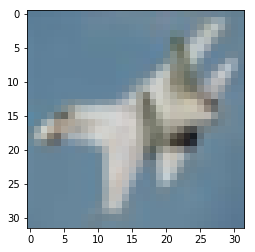

In [10]:
# Evaluate a sample image and display it
import matplotlib.pyplot as plt
from tensorflow.contrib import predictor

%matplotlib inline

image = eval_data[10].reshape(1,32,32,3)

predict_fn = predictor.from_saved_model(export_dir)
predictions = predict_fn({"x": image})

print("Class: ", predictions['classes'][0])

# Reshape the image as a 32x32x3 image
plt.imshow(image.reshape(32, 32, 3));

In [11]:
!chmod -R 777 logdir-big